In [1]:
import   warnings
import   pandas                  as       pd
import   numpy                   as       np
import   matplotlib.pyplot       as       plt
import   scipy                   as       sp
import   seaborn                 as       sn
import   data_cleaner_encoder    as       dce
from     sklearn                 import   preprocessing
from     sklearn.utils           import   shuffle
from     sklearn.multiclass      import   OneVsRestClassifier
from     sklearn.ensemble        import   RandomForestClassifier
from     sklearn.linear_model    import   LogisticRegression
from     sklearn.neighbors       import   KNeighborsClassifier
from     sklearn.tree            import   DecisionTreeClassifier
from     sklearn.metrics         import   make_scorer, hamming_loss
from     sklearn.metrics         import   classification_report, precision_recall_curve
from     sklearn.preprocessing   import   StandardScaler
from     sklearn.grid_search     import   GridSearchCV
from     sklearn.model_selection import   RandomizedSearchCV, train_test_split, cross_val_score

/usr/lib/python3/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/usr/lib/python3/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/lib/python3/dist-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
warnings.filterwarnings('ignore')
%matplotlib inline

# Data set for Training and Testing

In [3]:
def get_data():
    #Load the row data from the file 
    data = pd.read_csv('Africa_Vectors_database_1898-2016.csv', sep = ',', encoding = "ISO-8859-1")
    
    # remove white spaces at the begining and end of column names and labels in the columns
    Region = 'GAUL_Admin2'
    data.columns = data.columns.str.strip()
    data['Country']= data['Country'].str.strip()
    data[Region]= data[Region].str.strip()
    data['Adults/Larvae']= data['Adults/Larvae'].str.strip()

    # convert the 3 columns to Upper case
    data['Country'] = data['Country'].str.upper()
    data[Region] = data[Region].str.upper()
    data['Adults/Larvae'] = data['Adults/Larvae'].str.upper()

    #change the column name of Full_Name to Region
    data = data.rename(columns={Region: 'Region'})

    #Taking the mean over the two years, round is to make sure we do not have decimals in years 
    data['Year'] = list(round(data[['YeStart', 'YeEnd']].mean(axis=1)))

    #Selecting the features to keep
    features =['Country','Region', 'Lat', 'Long','Year', 'An gambiae_complex', 'An gambiae ss', 'SS M Form (An colluzzi or Mopti forms)', 'SS S Form (savanah or Bamako forms)','An arabiensis','An. melas','An. merus','An bwambae','An funestus  s.l','An funestus s.s. (specified)','An rivulorum','An leesoni','An parensis','An vaneedeni','An nili s.l','An moucheti s.l','An pharoensis','An hancocki','An mascarensis','An marshalli','An squamous','An wellcomei','An rufipes','An coustani s.l','An ziemanni','An paludis','Adults/Larvae']

    #Returning a dataset with only the features kept
    featured_data= data[features]

    #remove records with Lat,Long missing values 
    featured_data = featured_data.dropna(axis=0, subset=['Lat'])

    #encoding the species classes 
    encoded_data = featured_data.replace(np.nan,0).replace('Y',1)

    # Reseting the  index
    encoded_data=encoded_data.reset_index(drop=True)

    #encoding the labels columns 
    # Label encoding for Country, Region, and  Adults/Larvae columns 
    le = preprocessing.LabelEncoder()
    encoded_data['Country'] = le.fit_transform(encoded_data['Country'])
    encoded_data['Adults/Larvae'] = le.fit_transform(encoded_data['Adults/Larvae'])
    encoded_data['Region'] = le.fit_transform(encoded_data['Region'].astype(str))
    
    #normalize the data
    #encoded_data=(encoded_data-encoded_data.mean())/encoded_data.std()

    
    #normalize the longitude and latitude 
#     encoded_data['Lat']=(encoded_data['Lat']-encoded_data['Lat'].mean())/encoded_data['Lat'].std()
#     encoded_data['Long']=(encoded_data['Long']-encoded_data['Long'].mean())/encoded_data['Long'].std()
#     encoded_data['Year']=(encoded_data['Year']-encoded_data['Year'].mean())/encoded_data['Year'].std()
      
    #feature scaling for year, longitude and latitude 
    encoded_data['Lat']=(encoded_data['Lat']-encoded_data['Lat'].min())/encoded_data['Lat'].max()
    encoded_data['Long']=(encoded_data['Long']-encoded_data['Long'].min())/encoded_data['Long'].max()
    encoded_data['Year']=(encoded_data['Year']-encoded_data['Year'].min())/encoded_data['Year'].max()

    #convert the year column from float to int 
    #data = data.astype({'Year':'int'})
    encoded_data = shuffle(encoded_data)

    return encoded_data

In [4]:
encoded_data = get_data()
X = StandardScaler().fit_transform(np.array(encoded_data[encoded_data.columns[ :5]]))
y = np.array(encoded_data[encoded_data.columns[5:-1]])
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.20)

# Classification models and accuracy test

In [52]:
import numpy as np
import itertools
import matplotlib.pyplot as plt

def confusion_matrixI(yt, yp, classes):
    instcount = yt.shape[0]
    n_classes = classes.shape[0]
    mtx = np.zeros((n_classes, 4), dtype=int)
    for i in range(instcount):
        for c in range(n_classes):
            mtx[c,0] += 1 if yt[i,c]==1 and yp[i,c]==1 else 0
            mtx[c,1] += 1 if yt[i,c]==1 and yp[i,c]==0 else 0
            mtx[c,2] += 1 if yt[i,c]==0 and yp[i,c]==0 else 0
            mtx[c,3] += 1 if yt[i,c]==0 and yp[i,c]==1 else 0
    #mtx = [[m0/(m0+m1), m1/(m0+m1), m2/(m2+m3), m3/(m2+m3)] for m0,m1,m2,m3 in mtx]
    plt.figure(num=None, figsize=(18, 18), dpi=100, facecolor='w', edgecolor='k')
    plt.imshow(mtx, interpolation='nearest',cmap='Pastel2')
    plt.title("title")
    tick_marks = np.arange(n_classes)
    plt.xticks(np.arange(4), ['1 - 1','1 - 0','0 - 0','0 - 1'])
    plt.yticks(tick_marks, classes)
    for i, j in itertools.product(range(n_classes), range(4)):
        plt.text(j, i, round(mtx[i][j],2), horizontalalignment="center")

    plt.tight_layout()
    plt.ylabel('labels')
    plt.xlabel('Predicted')
    plt.savefig("confusion_matrix")
    plt.show()

In [6]:
def run_model(model, algname, targetnames, X, y):
    # build the model on training data
    model.fit(X, y)
    
    # make predictions for training data
    ypred = model.predict(X)
    
    print('--------------------------')
    print(algname, "Training accuracy: ", 100* np.sum(np.equal(ypred, y))/(y.size), 1 - hamming_loss(y, ypred))
    print('--------------------------')
    print(algname, "Loss: ", hamming_loss(y, ypred))
    print('--------------------------')
    print('Classification Report')
    print(classification_report(y, ypred, target_names=targetnames))
    print(' ')


In [7]:
targetnames = list(encoded_data.columns)[5:-1]

In [9]:
## -------------------- Random forest classifer --------------------
model = RandomForestClassifier()
algname = "Random Forest"
run_model(model, algname, targetnames, Xtrain, ytrain)



## -------------------- KNN classifer --------------------
model = KNeighborsClassifier(n_neighbors= 4)
algname = "K-Nearest Neighbour"
run_model(model, algname, targetnames, Xtrain, ytrain)



## -------------------- Decision tree classifer --------------------
model = DecisionTreeClassifier()
algname = "Decision Tree"
run_model(model, algname, targetnames, Xtrain, ytrain)


## -------------------- Logistic regression classifer --------------------
model = OneVsRestClassifier(LogisticRegression())
algname = "Logistic Regression"
run_model(model, algname, targetnames, Xtrain, ytrain)

--------------------------
Random Forest Training accuracy:  99.44962202088983 0.9944962202088984
--------------------------
Random Forest Loss:  0.005503779791101621
--------------------------
Classification Report
                                        precision    recall  f1-score   support

                    An gambiae_complex       1.00      1.00      1.00      9189
                         An gambiae ss       0.99      0.98      0.99      3179
SS M Form (An colluzzi or Mopti forms)       0.99      0.95      0.97      1031
   SS S Form (savanah or Bamako forms)       0.99      0.96      0.97      1249
                         An arabiensis       1.00      0.98      0.99      2884
                             An. melas       1.00      0.95      0.97       420
                             An. merus       1.00      0.89      0.94       198
                            An bwambae       1.00      1.00      1.00        26
                      An funestus  s.l       0.99      0.97    

# Hyperparameter Tuning

## A.  Random Forest Classifer

In [10]:
model1 = RandomForestClassifier(n_jobs = -1, oob_score = True, random_state= 123)
params = {
        'max_depth': np.array(range(10,100)),
         'max_features': ['auto', 'sqrt', 'log2'],
         'min_samples_leaf': np.array(range(1,10)),
         'min_samples_split': np.array(range(1,10)),
         'n_estimators': np.array(range(10,200))}

CV_model1 = RandomizedSearchCV(model1, params, cv= 20)
CV_model1.fit(Xtrain, ytrain)
optimal_params1 = CV_model1.best_params_
print("Grid Search results: ", optimal_params1)

Grid Search results:  {'min_samples_split': 3, 'max_depth': 80, 'n_estimators': 77, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


In [11]:
print("Before hyperparameter tuning: ")
model = RandomForestClassifier(random_state= 123)
algname = "Random Forest"
run_model(model, algname, targetnames, Xtrain, ytrain)
print(" ")

print("After hyperparameter tuning: ")
print("Random search opitmal values")
model = RandomForestClassifier(n_jobs= -1, max_features= optimal_params1['max_features'], 
                                                   oob_score= True, max_depth= optimal_params1['max_depth'],
                                                   min_samples_leaf = optimal_params1['min_samples_leaf'], 
                                                   n_estimators= optimal_params1['n_estimators'], 
                                                   min_samples_split= optimal_params1['min_samples_split'], 
                                                   random_state= 123)
algname = "Random Forest"
run_model(model, algname, targetnames, Xtrain, ytrain)

Before hyperparameter tuning: 
--------------------------
Random Forest Training accuracy:  99.44817935253045 0.9944817935253044
--------------------------
Random Forest Loss:  0.005518206474695597
--------------------------
Classification Report
                                        precision    recall  f1-score   support

                    An gambiae_complex       1.00      1.00      1.00      9189
                         An gambiae ss       1.00      0.98      0.99      3179
SS M Form (An colluzzi or Mopti forms)       0.99      0.95      0.97      1031
   SS S Form (savanah or Bamako forms)       1.00      0.96      0.98      1249
                         An arabiensis       1.00      0.98      0.99      2884
                             An. melas       0.99      0.95      0.97       420
                             An. merus       1.00      0.93      0.97       198
                            An bwambae       0.96      0.96      0.96        26
                      An funestu

## B.  KNeighbors Classifier

In [12]:
## Grid search

model2 = KNeighborsClassifier()
params = {"n_neighbors" : np.array(range(1, 21)), 
          "metric": ["euclidean", "cityblock"], 
          "weights" : ['uniform', 'distance']}

CV_model2 = GridSearchCV(model2 , params, cv = 20)
CV_model2.fit(Xtrain, ytrain)
optimal_params2_gs = CV_model2.best_params_
print("Grid Search results: ", optimal_params2_gs)

Grid Search results:  {'weights': 'distance', 'metric': 'cityblock', 'n_neighbors': 8}


In [13]:
## Randomized search

model2 = KNeighborsClassifier()
params = {"n_neighbors" : np.array(range(1, 21)), 
          "metric": ["euclidean", "cityblock"], 
          "weights" : ['uniform', 'distance']}

CV_model2 = RandomizedSearchCV(model2, params)
CV_model2.fit(Xtrain, ytrain)
optimal_params2_rs = CV_model2.best_params_
print("Random Search results: ", optimal_params2_rs)

Random Search results:  {'metric': 'cityblock', 'n_neighbors': 14, 'weights': 'distance'}


In [14]:
print("Before hyperparameter tuning: ")
model = KNeighborsClassifier(n_neighbors= 4)
algname = "K-Nearest Neighbour"
run_model(model, algname, targetnames, Xtrain, ytrain)

print(" ")

print("After hyperparameter tuning: ")
print("Grid search optimal values")
model = KNeighborsClassifier(n_neighbors= optimal_params2_gs['n_neighbors'], 
                             metric = optimal_params2_gs['metric'], 
                             weights= optimal_params2_gs['weights'])
algname = "K-Nearest Neighbour"
run_model(model, algname, targetnames, Xtrain, ytrain)

print(" ")  

print("Random search opitmal values")
model = KNeighborsClassifier(n_neighbors= optimal_params2_rs['n_neighbors'], 
                             metric = optimal_params2_rs['metric'], 
                             weights= optimal_params2_rs['weights'])
algname = "K-Nearest Neighbour"
run_model(model, algname, targetnames, Xtrain, ytrain)

Before hyperparameter tuning: 
--------------------------
K-Nearest Neighbour Training accuracy:  95.61717352415027 0.9561717352415027
--------------------------
K-Nearest Neighbour Loss:  0.04382826475849732
--------------------------
Classification Report
                                        precision    recall  f1-score   support

                    An gambiae_complex       0.96      0.94      0.95      9189
                         An gambiae ss       0.92      0.79      0.85      3179
SS M Form (An colluzzi or Mopti forms)       0.90      0.61      0.73      1031
   SS S Form (savanah or Bamako forms)       0.91      0.66      0.77      1249
                         An arabiensis       0.92      0.77      0.84      2884
                             An. melas       0.84      0.57      0.68       420
                             An. merus       0.83      0.42      0.56       198
                            An bwambae       0.95      0.77      0.85        26
                     

## C. Decision Tree Classifier

In [15]:
model3 = DecisionTreeClassifier(random_state= 123)
params = {
        'max_depth': np.array(range(10,100)),
         'max_features': ['auto', 'sqrt', 'log2'],
         'min_samples_leaf': np.array(range(1,10)),
         'min_samples_split': np.array(range(1,10))}

CV_model3 = RandomizedSearchCV(model3, params)
CV_model3.fit(Xtrain, ytrain)
optimal_params3 = CV_model3.best_params_
print("Random Search results: ", optimal_params3)

Random Search results:  {'min_samples_split': 7, 'max_depth': 99, 'min_samples_leaf': 3, 'max_features': 'sqrt'}


In [16]:
print("Before hyperparameter tuning: ")
model = DecisionTreeClassifier(random_state= 123)
algname = "Decision Tree"
run_model(model, algname, targetnames, Xtrain, ytrain)
print(" ")

print("Random search opitmal values")
model = DecisionTreeClassifier(min_samples_split= optimal_params3['min_samples_split'], 
                               max_depth= optimal_params3['max_depth'] , 
                               max_features= optimal_params3['max_features'], 
                               min_samples_leaf= optimal_params3['min_samples_leaf'], 
                               random_state= 123)
algname = "Decision Tree"
run_model(model, algname, targetnames, Xtrain, ytrain)

Before hyperparameter tuning: 
--------------------------
Decision Tree Training accuracy:  99.9992786658203 0.999992786658203
--------------------------
Decision Tree Loss:  7.213341796987709e-06
--------------------------
Classification Report
                                        precision    recall  f1-score   support

                    An gambiae_complex       1.00      1.00      1.00      9189
                         An gambiae ss       1.00      1.00      1.00      3179
SS M Form (An colluzzi or Mopti forms)       1.00      1.00      1.00      1031
   SS S Form (savanah or Bamako forms)       1.00      1.00      1.00      1249
                         An arabiensis       1.00      1.00      1.00      2884
                             An. melas       1.00      1.00      1.00       420
                             An. merus       1.00      1.00      1.00       198
                            An bwambae       1.00      1.00      1.00        26
                      An funestus

## D. Logistic Regression

In [17]:
acc = np.zeros((2,100))
penalty = ['l1', 'l2']
C = np.array(range(1, 101))/100
for p in range(len(penalty)):
    for c in range(len(C)):
        lr = OneVsRestClassifier(LogisticRegression(penalty = penalty[p], C = C[c]))
        lr.fit(Xtrain, ytrain)
        ypred = lr.predict(Xtrain)
        acc[p, c] = 100* np.sum(np.equal(ypred, ytrain))/(ytrain.size)
        
indx_max= np.argmax(acc)
if indx_max < 100:
    p, c = 0, indx_max
else:
    p, c = 1, indx_max - 99

In [18]:
print("Before hyperparameter tuning: ")
model = OneVsRestClassifier(LogisticRegression())
algname = "Logistic Regression"
run_model(model, algname, targetnames, Xtrain, ytrain)
print(" ")

print("After hyperparameter tuning: ")
print("Random search opitmal values")
model = OneVsRestClassifier(LogisticRegression(penalty = penalty[p], C = C[c]))
algname = "Logistic Regression"
run_model(model, algname, targetnames, Xtrain, ytrain)

Before hyperparameter tuning: 
--------------------------
Logistic Regression Training accuracy:  91.73459230192164 0.9173459230192164
--------------------------
Logistic Regression Loss:  0.08265407698078366
--------------------------
Classification Report
                                        precision    recall  f1-score   support

                    An gambiae_complex       0.86      0.99      0.92      9189
                         An gambiae ss       0.66      0.55      0.60      3179
SS M Form (An colluzzi or Mopti forms)       0.58      0.34      0.43      1031
   SS S Form (savanah or Bamako forms)       0.64      0.33      0.44      1249
                         An arabiensis       0.54      0.36      0.43      2884
                             An. melas       0.00      0.00      0.00       420
                             An. merus       0.00      0.00      0.00       198
                            An bwambae       0.00      0.00      0.00        26
                     

# Model Evaluation

In [19]:
my_score_fun = lambda y, ypred: 1 - hamming_loss(y, ypred)
scorer = make_scorer(my_score_fun, greater_is_better= True)

In [34]:
lr = OneVsRestClassifier(LogisticRegression(penalty = penalty[p], C = C[c]))
scores1 = cross_val_score(lr, Xtrain, ytrain, scoring = scorer, cv= 20)
print(scores1)
print("Logistic regression accuracy: {}, +/- {})".format(scores1.mean(), (scores1.std() * 2)))

[0.91868338 0.91853933 0.9130654  0.91630654 0.91752057 0.91355174
 0.91456199 0.92026266 0.91283013 0.9143455  0.92444797 0.91838649
 0.92141723 0.92011834 0.91737624 0.91824217 0.91145909 0.91658248
 0.91997402 0.91694328]
Logistic regression accuracy: 0.9172307278803788, +/- 0.006345460473207805)


In [35]:
dtc = DecisionTreeClassifier(min_samples_split= optimal_params3['min_samples_split'], 
                               max_depth= optimal_params3['max_depth'] , 
                               max_features= optimal_params3['max_features'], 
                               min_samples_leaf= optimal_params3['min_samples_leaf'], 
                               random_state= 123)

scores2 = cross_val_score(dtc, Xtrain, ytrain, scoring = scorer, cv= 20)
print(scores2)
print("Decision Tree Classifer accuracy: {}, +/- {})".format(scores2.mean(), (scores2.std() * 2)))

[0.93431288 0.93524921 0.93366465 0.93618554 0.93635445 0.92690143
 0.9315197  0.93657093 0.92978785 0.9342618  0.94147785 0.92957137
 0.93895223 0.93556069 0.93779766 0.93642661 0.93079809 0.93440612
 0.93469476 0.93418964]
Decision Tree Classifer accuracy: 0.9344341726111229, +/- 0.006678631845442249)


In [36]:
knn = KNeighborsClassifier(n_neighbors= optimal_params2_rs['n_neighbors'], 
                             metric = optimal_params2_rs['metric'], 
                             weights= optimal_params2_rs['weights'])

scores3 = cross_val_score(knn, Xtrain, ytrain, scoring = scorer, cv= 20)
print(scores3)
print("KNearest Neighbor accuracy: {}, +/- {})".format(scores3.mean(), (scores3.std() * 2)))

[0.94273984 0.94410833 0.94129934 0.93899453 0.94566315 0.93779766
 0.93888007 0.94674556 0.93989032 0.94025112 0.94927118 0.94104488
 0.94616828 0.94126137 0.94176649 0.94248809 0.9373647  0.94234377
 0.94248809 0.94371482]
KNearest Neighbor accuracy: 0.94221407961869, +/- 0.006020296681809203)


In [39]:
rf = RandomForestClassifier(n_jobs= -1, max_features= optimal_params1['max_features'], 
                                                   oob_score= True, max_depth= optimal_params1['max_depth'],
                                                   min_samples_leaf = optimal_params1['min_samples_leaf'], 
                                                   n_estimators= optimal_params1['n_estimators'], 
                                                   min_samples_split= optimal_params1['min_samples_split'], 
                                                   random_state= 123)
scores4 = cross_val_score(knn, Xtrain, ytrain, scoring = scorer, cv= 20)
print(scores4)
print("Random Forest accuracy: {}, +/- {})".format(scores4.mean(), (scores4.std() * 2)))

[0.94273984 0.94410833 0.94129934 0.93899453 0.94566315 0.93779766
 0.93888007 0.94674556 0.93989032 0.94025112 0.94927118 0.94104488
 0.94616828 0.94126137 0.94176649 0.94248809 0.9373647  0.94234377
 0.94248809 0.94371482]
Random Forest accuracy: 0.94221407961869, +/- 0.006020296681809203)


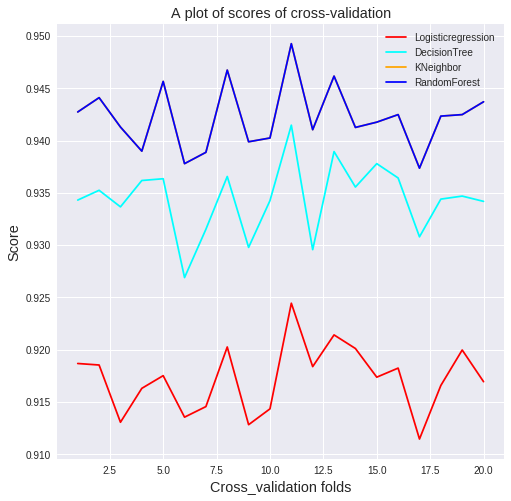

In [62]:
plt.figure(figsize=(8,8))
plt.plot(np.arange(1,21), scores1, label= "Logisticregression", color = 'red')
plt.plot(np.arange(1,21), scores2, label="DecisionTree", color = 'cyan')
plt.plot(np.arange(1,21), scores3, label = "KNeighbor", color = 'orange')
plt.plot(np.arange(1,21), scores4, label= "RandomForest", color = 'blue')
plt.title("A plot of scores of cross-validation", size ="x-large")
plt.xlabel("Cross_validation folds", size ="x-large")
plt.ylabel("Score", size ="x-large")
plt.legend()
plt.savefig('cross_varim')

# Model Selection

### We select the model with the highest accuracy or least loss after cross validation and predict for the test set

In [50]:
def run_model(model, algname, targetnames, Xtrain, ytrain, Xtest, ytest):
    # build the model on training data
    model.fit(Xtrain, ytrain)
    
    # make predictions for testing data
    ypred = model.predict(Xtest)
    
    print('--------------------------')
    print(algname, "Training accuracy: ", 100* np.sum(np.equal(model.predict(Xtrain), ytrain))/(ytrain.size), hamming_loss(ytrain, model.predict(Xtrain)))
    print('--------------------------')
    print(algname, "Testing accuracy: ", 100* np.sum(np.equal(ypred, ytest))/(ytest.size), 1 - hamming_loss(ytest, ypred))
    print('--------------------------')
    print(algname, "Loss: ", hamming_loss(ytest, ypred))
    print('--------------------------')
    confusion_matrixI(ytest, ypred, np.array(targetnames))    
    print('--------------------------')
    print('Classification Report')
    print(classification_report(ytest, ypred, target_names=targetnames))
    print(' ')


--------------------------
Random Forest Training accuracy:  99.54700213514917 0.0045299786485082805
--------------------------
Random Forest Testing accuracy:  94.40966010733453 0.9440966010733453
--------------------------
Random Forest Loss:  0.05590339892665474
--------------------------


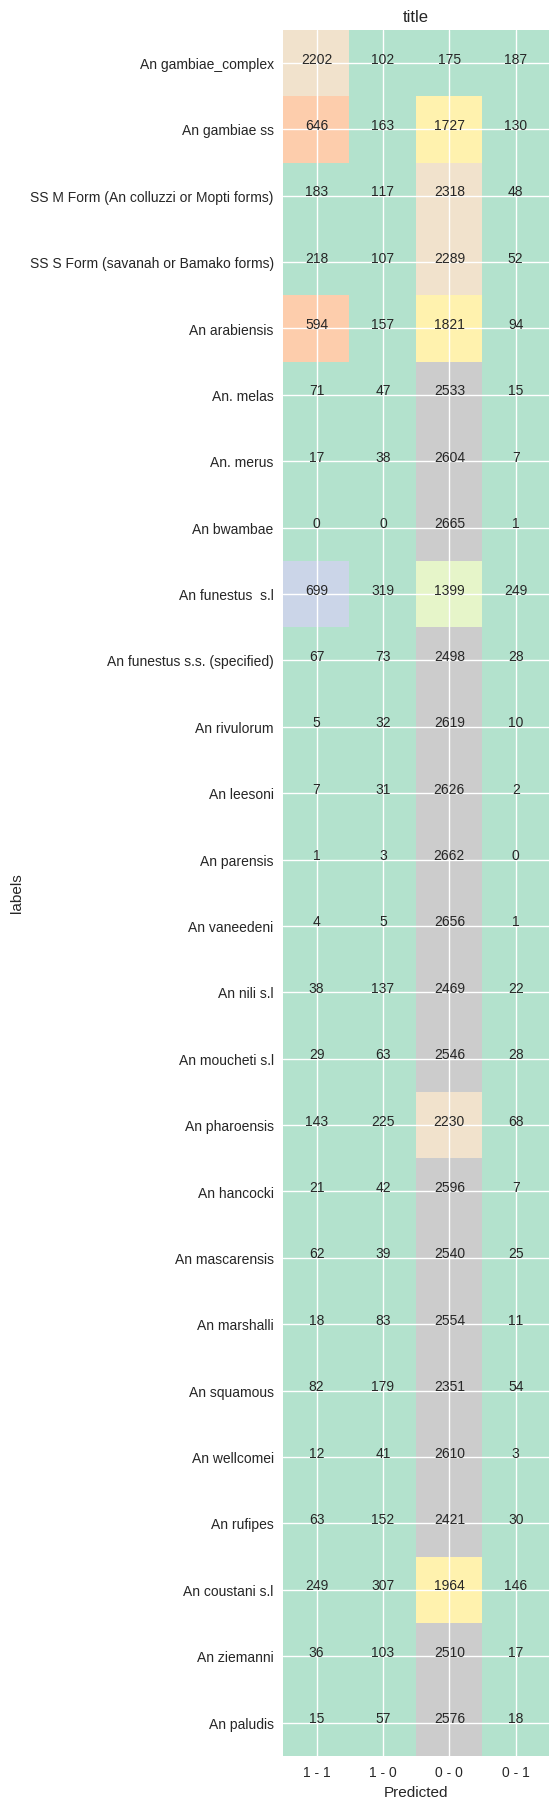

--------------------------
Classification Report
                                        precision    recall  f1-score   support

                    An gambiae_complex       0.92      0.96      0.94      2304
                         An gambiae ss       0.83      0.80      0.82       809
SS M Form (An colluzzi or Mopti forms)       0.79      0.61      0.69       300
   SS S Form (savanah or Bamako forms)       0.81      0.67      0.73       325
                         An arabiensis       0.86      0.79      0.83       751
                             An. melas       0.83      0.60      0.70       118
                             An. merus       0.71      0.31      0.43        55
                            An bwambae       0.00      0.00      0.00         0
                      An funestus  s.l       0.74      0.69      0.71      1018
          An funestus s.s. (specified)       0.71      0.48      0.57       140
                          An rivulorum       0.33      0.14      0.19 

In [53]:
 model = RandomForestClassifier(n_jobs= -1, max_features= optimal_params1['max_features'], 
                                                   oob_score= True, max_depth= optimal_params1['max_depth'],
                                                   min_samples_leaf = optimal_params1['min_samples_leaf'], 
                                                   n_estimators= optimal_params1['n_estimators'], 
                                                   min_samples_split= optimal_params1['min_samples_split'], 
                                                   random_state= 123)
algname = "Random Forest" 
run_model(model, algname, targetnames, Xtrain, ytrain, Xtest, ytest)

--------------------------
K-Nearest Neighbour Training accuracy:  99.9992786658203 0.999992786658203
--------------------------
K-Nearest Neighbour Testing accuracy:  94.06486236943852 0.9406486236943852
--------------------------
K-Nearest Neighbour Loss:  0.059351376305614864
--------------------------


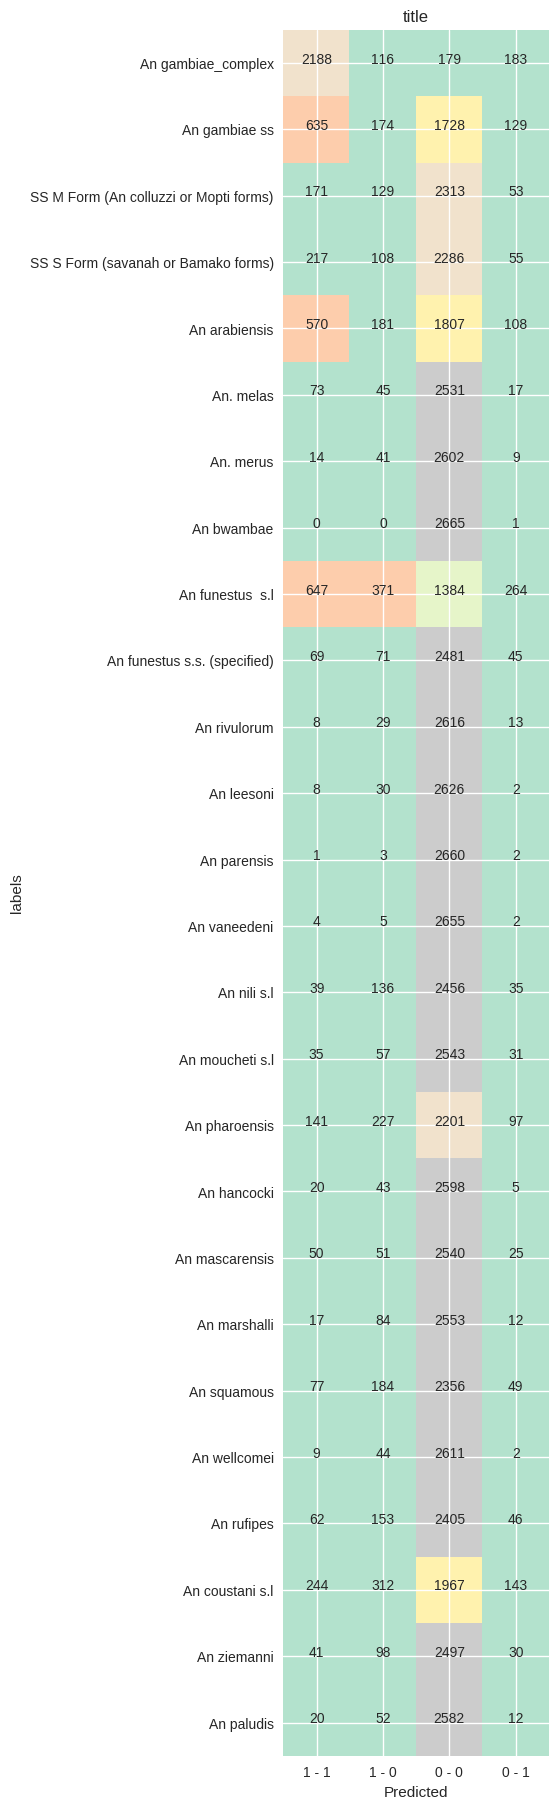

--------------------------
Classification Report
                                        precision    recall  f1-score   support

                    An gambiae_complex       0.92      0.95      0.94      2304
                         An gambiae ss       0.83      0.78      0.81       809
SS M Form (An colluzzi or Mopti forms)       0.76      0.57      0.65       300
   SS S Form (savanah or Bamako forms)       0.80      0.67      0.73       325
                         An arabiensis       0.84      0.76      0.80       751
                             An. melas       0.81      0.62      0.70       118
                             An. merus       0.61      0.25      0.36        55
                            An bwambae       0.00      0.00      0.00         0
                      An funestus  s.l       0.71      0.64      0.67      1018
          An funestus s.s. (specified)       0.61      0.49      0.54       140
                          An rivulorum       0.38      0.22      0.28 

In [26]:
model = KNeighborsClassifier(n_neighbors= optimal_params2_rs['n_neighbors'], 
                             metric = optimal_params2_rs['metric'], 
                             weights= optimal_params2_rs['weights'])
algname = "K-Nearest Neighbour"
run_model(model, algname, targetnames, Xtrain, ytrain, Xtest, ytest)

--------------------------
Decision Tree Training accuracy:  96.27430896185585 0.9627430896185585
--------------------------
Decision Tree Testing accuracy:  93.32477350106757 0.9332477350106757
--------------------------
Decision Tree Loss:  0.06675226498932425
--------------------------


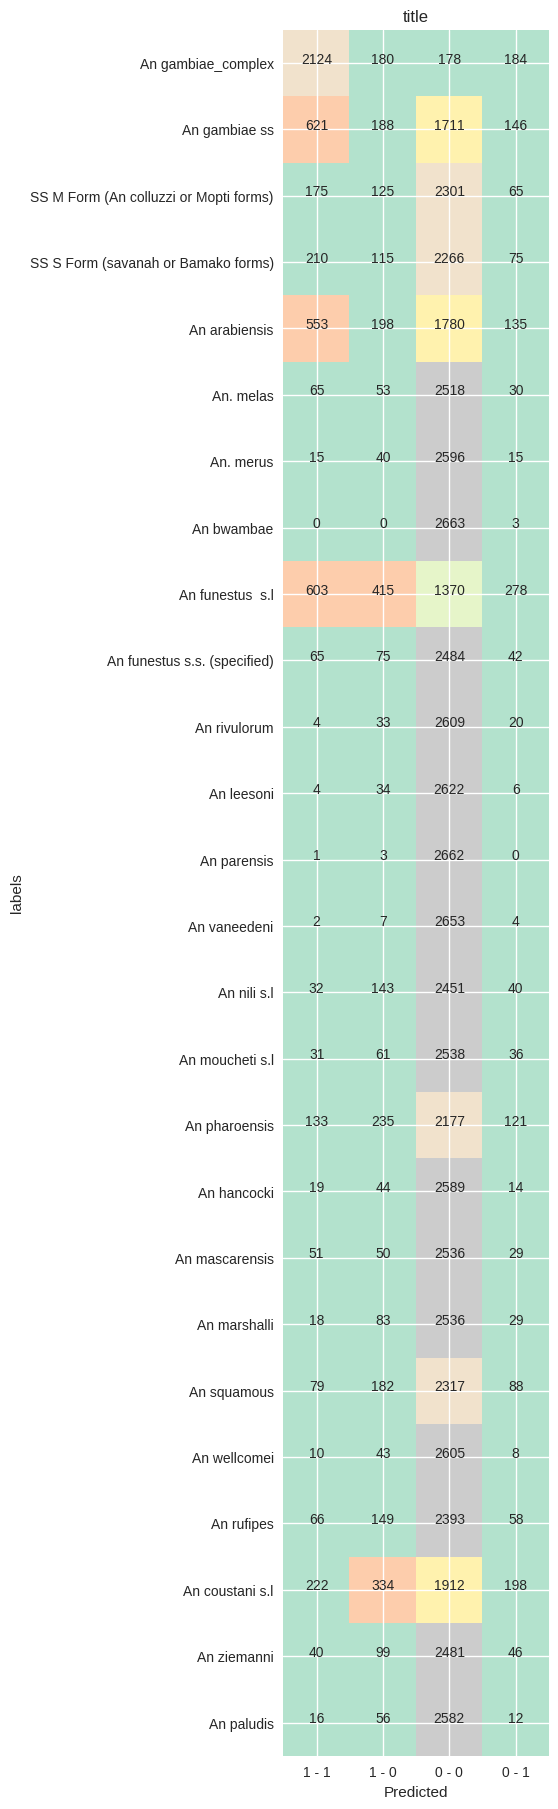

--------------------------
Classification Report
                                        precision    recall  f1-score   support

                    An gambiae_complex       0.92      0.92      0.92      2304
                         An gambiae ss       0.81      0.77      0.79       809
SS M Form (An colluzzi or Mopti forms)       0.73      0.58      0.65       300
   SS S Form (savanah or Bamako forms)       0.74      0.65      0.69       325
                         An arabiensis       0.80      0.74      0.77       751
                             An. melas       0.68      0.55      0.61       118
                             An. merus       0.50      0.27      0.35        55
                            An bwambae       0.00      0.00      0.00         0
                      An funestus  s.l       0.68      0.59      0.64      1018
          An funestus s.s. (specified)       0.61      0.46      0.53       140
                          An rivulorum       0.17      0.11      0.13 

In [27]:
model = DecisionTreeClassifier(min_samples_split= optimal_params3['min_samples_split'], 
                               max_depth= optimal_params3['max_depth'] , 
                               max_features= optimal_params3['max_features'], 
                               min_samples_leaf= optimal_params3['min_samples_leaf'], 
                               random_state= 123)
algname = "Decision Tree"
run_model(model, algname, targetnames, Xtrain, ytrain, Xtest, ytest)

--------------------------
Logistic Regression Training accuracy:  91.74324831207802 0.9174324831207802
--------------------------
Logistic Regression Testing accuracy:  91.52720872525823 0.9152720872525824
--------------------------
Logistic Regression Loss:  0.08472791274741763
--------------------------


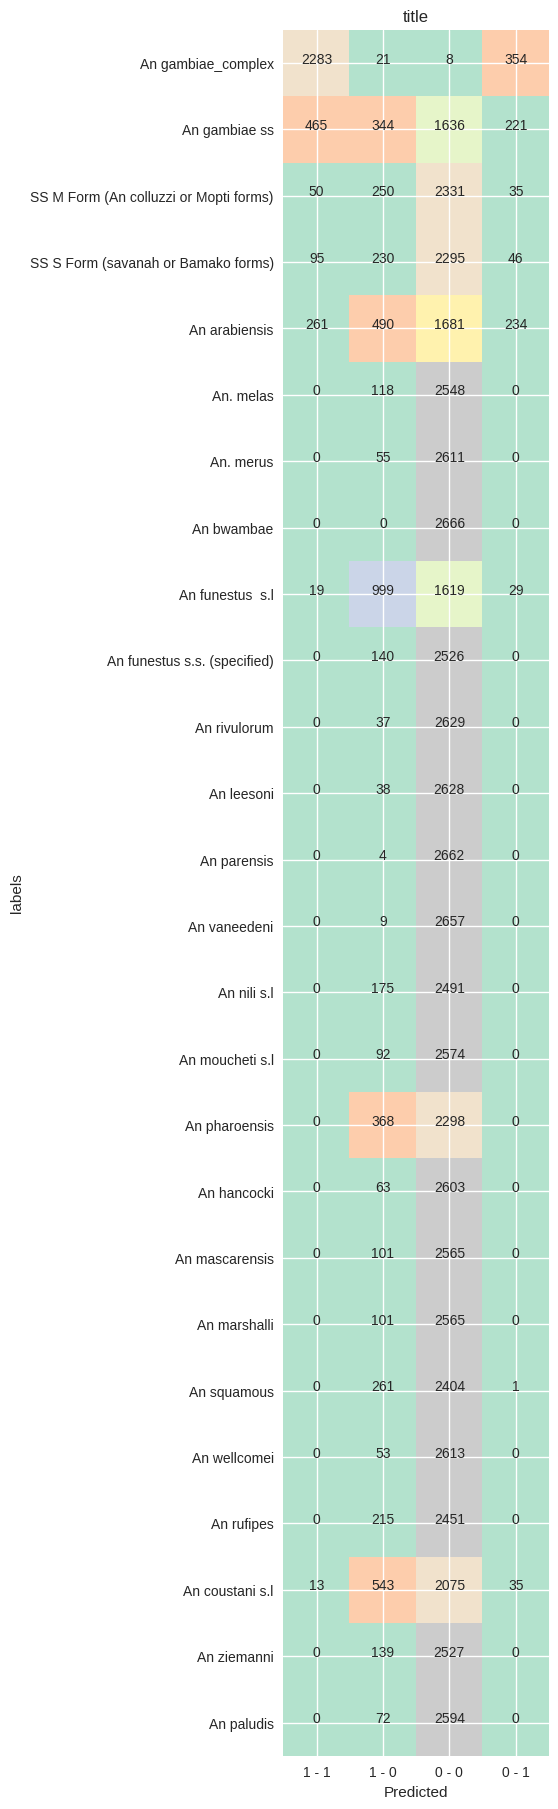

--------------------------
Classification Report
                                        precision    recall  f1-score   support

                    An gambiae_complex       0.87      0.99      0.92      2304
                         An gambiae ss       0.68      0.57      0.62       809
SS M Form (An colluzzi or Mopti forms)       0.59      0.17      0.26       300
   SS S Form (savanah or Bamako forms)       0.67      0.29      0.41       325
                         An arabiensis       0.53      0.35      0.42       751
                             An. melas       0.00      0.00      0.00       118
                             An. merus       0.00      0.00      0.00        55
                            An bwambae       0.00      0.00      0.00         0
                      An funestus  s.l       0.40      0.02      0.04      1018
          An funestus s.s. (specified)       0.00      0.00      0.00       140
                          An rivulorum       0.00      0.00      0.00 

In [28]:
model = OneVsRestClassifier(LogisticRegression(penalty = penalty[p], C = C[c]))
algname = "Logistic Regression"
run_model(model, algname, targetnames, Xtrain, ytrain, Xtest, ytest)

In [29]:
# rfc = RandomForestClassifier(n_jobs= -1, max_features= optimal_params1['max_features'], 
#                                                    oob_score= True, max_depth= optimal_params1['max_depth'],
#                                                    min_samples_leaf = optimal_params1['min_samples_leaf'], 
#                                                    n_estimators= optimal_params1['n_estimators'], 
#                                                    min_samples_split= optimal_params1['min_samples_split'], 
#                                                    random_state= 123)

# rfc.fit(Xtrain, ytrain)
# yscore = rfc.predict_proba(Xtest)
# pre_rec_curve(ytest, yscore)

# dtc = DecisionTreeClassifier(min_samples_split= optimal_params3['min_samples_split'], 
#                                max_depth= optimal_params3['max_depth'] , 
#                                max_features= optimal_params3['max_features'], 
#                                min_samples_leaf= optimal_params3['min_samples_leaf'], 
#                                random_state= 123)
# dtc.fit(Xtrain, ytrain)
# yscore = dtc.decision_function(Xtest)
# pre_rec_curve(ytest, yscore)

# knn = KNeighborsClassifier(n_neighbors= optimal_params2_rs['n_neighbors'], 
#                              metric = optimal_params2_rs['metric'], 
#                              weights= optimal_params2_rs['weights'])

# knn.fit(Xtrain, ytrain)
# yscore = knn.decision_function(Xtest)
# pre_rec_curve(ytest, yscore)

# lg = OneVsRestClassifier(LogisticRegression(penalty = penalty[p], C = C[c]))
# lg.fit(Xtrain, ytrain)
# yscore = lg.decision_function(Xtest)
# pre_rec_curve(ytest, yscore)